# COG403 Project - Mizna & Jiessie
## Affective Ratings of Words: Exploring the Predictive Power of Linguistic Features

## STEP 1: Feature Extraction
In this step, we organize the datasets which contain features for a large set of words. From there, the features are extracted and stored in data structures such as lists and dictionaries.

In [2]:
# Important necessary libraries
import csv
import pandas as pd
import string
import numpy as np
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
import sklearn
from itertools import tee, islice
from scipy.stats import norm
from sklearn.decomposition import PCA

### Dataset Organization
In this section, we prune extra and redundant data. We first do a join on the datasets according to the overlapping words. resulting in a large dataset.
 
We then delete columns holding data for unnecessary features, outputting the data we will be using throughout the rest of the project.

In [3]:
word_prev = pd.read_excel(r'Wordprevalences.xlsx')
rt_conc_aoa_prev = pd.read_csv('reaction_time_all.csv')
affective_scores = pd.read_csv('Ratings_Warriner_et_al.csv')


half = pd.merge(word_prev, rt_conc_aoa_prev, on=['Word'], how='inner')
full_dataset = pd.merge(half, affective_scores, on=['Word'], how='inner')

delete_attr = ['Pknown', 'Nobs', 'Lemma', 'OLD', 'PLD', 'V.Mean.M', 'V.SD.M', 'V.Rat.M', 'V.Mean.F', 'V.SD.F', 'V.Rat.F', 'A.Mean.M', 'A.SD.M', 
               'A.Rat.M', 'A.Mean.F', 'A.SD.F', 'A.Rat.F', 'D.Mean.M', 'D.SD.M', 'D.Rat.M', 'D.Mean.F', 'D.SD.F', 'D.Rat.F', 
               'V.Mean.Y', 'V.SD.Y', 'V.Rat.Y', 'V.Mean.O', 'V.SD.O', 'V.Rat.O', 'A.Mean.Y', 'A.SD.Y', 'A.Rat.Y', 'A.Mean.O', 
               'A.SD.O', 'A.Rat.O', 'D.Mean.Y', 'D.SD.Y', 'D.Rat.Y', 'D.Mean.O', 'D.SD.O', 'D.Rat.O', 'V.Mean.L', 'V.SD.L', 
               'V.Rat.L', 'V.Mean.H', 'V.SD.H', 'V.Rat.H', 'A.Mean.L', 'A.SD.L', 'A.Rat.L', 'A.Mean.H', 'A.SD.H', 'A.Rat.H', 
               'D.Mean.L', 'D.SD.L', 'D.Rat.L', 'D.Mean.H', 'D.SD.H', 'D.Rat.H', "Unnamed: 0", "Prevalence_y", 
               "ECP_RT", "ECP_High", "ECP_Bach", "ECP_Mast", "ECP_18", "ECP_24", "ECP_30", "ECP_40", "ECP_50", 
               "zECP_18", "zECP_24", "zECP_30", "zECP_40", "zECP_50", "weigh24", "av24", "weigh50", "av50"]

feature_dataset = full_dataset.drop(columns=delete_attr, axis=1)

In [4]:
feature_dataset.columns.values.tolist()
len(feature_dataset)

11460

### Labelling

In this section, we are creating and assigning category labels for each word. There are four valence-arousal categories; High-Arousal, Positive-Valence, High-Arousal, Negative-Valence, Low-Arousal, Positive-Valence and Low-Arousal, Negative-Valence.

The score threshold between them is at 5, which is how we are categorizing in the code below.

In [5]:
# more than 5 in Valence, More than 5 in arousal
# less than 5 in Valence, more than 5 in arousal
# more than 5 in Valence, less than 5 in arousal
# less than 5 in valence, less than 5 in arousal

def label_category(v, a):
    if a > 5:
        if v > 5:
            return "High-Arousal, Positive-Valence"
        
        else:
            return "High-Arousal, Negative-Valence"
    else:
        if v > 5:
            return "Low-Arousal, Positive-Valence"
        else:
            return "Low-Arousal, Negative-Valence"

feature_dataset['VA_Category'] = feature_dataset.apply(lambda row: label_category(row['V.Mean.Sum'], row['A.Mean.Sum']), axis=1)
# feature_dataset['VA_Category']

### Balancing the Category Sample sets
Below, we are checking the number of words in each category. This allows us to balance the dataset by sampling an equal number of words in each category. 

In [6]:
print(feature_dataset[feature_dataset['VA_Category'] == "High-Arousal, Positive-Valence"].shape[0])
print(feature_dataset[feature_dataset['VA_Category'] == "High-Arousal, Negative-Valence"].shape[0])
print(feature_dataset[feature_dataset['VA_Category'] == "Low-Arousal, Positive-Valence"].shape[0])
print(feature_dataset[feature_dataset['VA_Category'] == "Low-Arousal, Negative-Valence"].shape[0])


highA_posV = feature_dataset[feature_dataset['VA_Category'] == "High-Arousal, Positive-Valence"].sample(n=935)
highA_negV = feature_dataset[feature_dataset['VA_Category'] == "High-Arousal, Negative-Valence"].sample(n=935)
lowA_posV = feature_dataset[feature_dataset['VA_Category'] == "Low-Arousal, Positive-Valence"].sample(n=935)
lowA_negV = feature_dataset[feature_dataset['VA_Category'] == "Low-Arousal, Negative-Valence"].sample(n=935)

balanced_dataset = pd.concat([highA_posV, highA_negV, lowA_posV, lowA_negV])

balanced_dataset


935
1212
5701
3612


,Word,Prevalence_x,FreqZipfUS,Length,SubtlexZipf,Ortho_N,Phono_N,NPhon,NSyll,NMorph,...,V.Mean.Sum,V.SD.Sum,V.Rat.Sum,A.Mean.Sum,A.SD.Sum,A.Rat.Sum,D.Mean.Sum,D.SD.Sum,D.Rat.Sum,VA_Category
5304,intelligence,2.314933,4.284829,12,4.284829,0,1,10,4,2,...,7.65,1.09,20,6.32,2.36,19,6.72,2.19,25,"High-Arousal, Positive-Valence"
4158,galaxy,2.326348,3.823313,6,3.823313,0,0,7,3,1,...,5.95,1.96,19,5.61,2.30,18,4.76,2.75,17,"High-Arousal, Positive-Valence"
7795,promotion,2.052179,4.038468,9,4.038468,0,0,7,3,3,...,7.10,2.20,20,5.21,2.99,47,6.00,2.29,19,"High-Arousal, Positive-Valence"
1110,bourbon,2.008073,3.796984,7,3.796984,0,3,5,2,1,...,5.70,2.43,20,5.95,2.95,20,5.69,2.09,26,"High-Arousal, Positive-Valence"
2062,congratulation,1.512227,2.706807,14,2.706807,0,0,12,5,2,...,7.30,1.13,20,6.05,2.31,20,6.68,2.12,25,"High-Arousal, Positive-Valence"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8369,repugnant,1.989313,2.893894,9,2.893894,0,1,9,3,2,...,2.83,1.62,18,3.64,2.56,22,4.04,2.20,23,"Low-Arousal, Negative-Valence"
6072,marginal,1.955704,2.754232,8,2.754232,0,1,7,3,2,...,4.60,1.05,20,3.57,1.54,21,5.47,2.02,34,"Low-Arousal, Negative-Valence"
5456,jaw,2.575829,3.854127,3,3.854127,11,13,2,1,1,...,4.41,1.01,22,4.09,2.35,23,5.84,1.92,19,"Low-Arousal, Negative-Valence"
3609,extinguish,2.151604,2.935287,10,2.935287,0,0,10,3,1,...,4.65,1.66,20,4.91,2.43,22,5.47,2.48,19,"Low-Arousal, Negative-Valence"


Here we are separating the word features from their labels

In [7]:
features = balanced_dataset.drop(columns=['Word', 'V.Mean.Sum', 'V.SD.Sum', 'V.Rat.Sum',  
                                          'A.Mean.Sum', 'A.SD.Sum', 'A.Rat.Sum','VA_Category'], axis=1)
labels  = balanced_dataset['VA_Category']

features.index
# labels

Int64Index([5304, 4158, 7795, 1110, 2062, 6049, 6522, 2283, 4060, 9980,
            ...
             508, 6152, 6021, 2229, 9194, 8369, 6072, 5456, 3609, 2054],
           dtype='int64', length=3740)

##  STEP 2: Categorization

In this section, we train and test different categorization methods, in order to accurately classify a word into the correct VA category, using only the words' linguistic features.

We are using five different classifiers such as AdaBoost, Random Forest, Decision Tree, KNeighbors and Gaussian Naive Bayes Classifiers. We train and test them on our formatted dataset and compare the accuracies.

The most accurate classifier and its generated categorizations are cross-validated using k-fold of 5 and saved to be used throughout the rest of the project.

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from scipy.stats import ttest_rel
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


# try different classifiers
# set the random state for reproducibility 

np.random.seed(403)
dt = DecisionTreeClassifier(max_depth=3)

    
classifier_list = [ 
                    AdaBoostClassifier(base_estimator=dt, learning_rate=0.5, n_estimators=50),
                    RandomForestClassifier(max_depth=5, n_estimators=10), 
                    DecisionTreeClassifier(),
                    KNeighborsClassifier(n_neighbors=5), 
                    GaussianNB(),
                ]

model_names = [ 
                'AdaBoostClassifier',
                "RandomForestClassifier", 
                "DecisionTreeClassifier",
                'KNeighborsClassifier',
                "GaussianNaiveBayes",
               ]

def accuracy(C):
    return np.sum(np.diag(C)) / C.sum()
    

def recall(C):
    return np.diag(C) / np.sum(C, axis=1)


def precision(C):
    return np.diag(C) / C.sum(axis=0)


def best_classifier(X_train, X_test, y_train, y_test):
    best_accuracy = 0
    best_classifier = -1

    for i in range(len(classifier_list)):
        classify_model = classifier_list[i].fit(X_train, y_train)
        y_predict = classify_model.predict(X_test)

        c_matrix = confusion_matrix(y_test, y_predict)
        acc = accuracy(c_matrix)
        recall_var = recall(c_matrix)
        precision_var = precision(c_matrix)

        classifier_name = model_names[i]

        print('Results for ', classifier_name, '\n')  # Classifier name
        print('Accuracy:', acc)
        print('Recall:', recall_var)
        print('Precision:', precision_var)
        print('Confusion Matrix:', c_matrix, '\n')

        if acc >= best_accuracy:
            best_accuracy = acc
            best_classifier = i
            prediction_list = y_predict

    #cross validation
    kfold_accuracies_dict = {model_index: [0] * 5 for model_index in range(len(model_names))}

    kf = KFold(n_splits=5, random_state=401, shuffle=True)

    combinex = np.concatenate([X_train, X_test])
    combiney = np.concatenate([y_train, y_test])

    for j, (train_idx, valid_idx) in enumerate(kf.split(combinex)):
        # Get the j^th training and validation sets
        kfold_accuracies = []
        index = 0
        for m in classifier_list:
            #Get training and validation data
            X_train2, X_valid = combinex[train_idx], combinex[valid_idx]
            y_train2, y_valid = combiney[train_idx], combiney[valid_idx]
            
            #Train the data
            m.fit(X_train2, y_train2)
            predictions = m.predict(X_valid)
            conf_matrix = confusion_matrix(y_valid, predictions)

            # Get accuracies for each model
            kfold_accuracies.append(accuracy(conf_matrix))
            
            
            kfold_accuracies_dict[index][j] = accuracy(conf_matrix)

            #Append accuracy for the models
            index+=1
    print('Kfold Accuracies:', kfold_accuracies_dict)


    p_values = []
    for j in range(len(kfold_accuracies_dict)):
        if j != best_classifier:
            pval_test = ttest_rel(kfold_accuracies_dict[j], kfold_accuracies_dict[best_classifier])[1]
            p_values.append(pval_test)
    print('p-values: ', p_values)
    
    return best_classifier, prediction_list


X_train, X_test, y_train, y_test  = train_test_split(features, labels, test_size=0.25)
#make sure labels are balanced in test set
# report class imbalance

best_classifier_index, prediction_list = best_classifier(X_train, X_test, y_train, y_test)
#k fold

Results for  AdaBoostClassifier 

Accuracy: 0.3888888888888889
Recall: [0.48148148 0.45901639 0.26229508 0.36206897]
Precision: [0.44827586 0.53846154 0.27586207 0.31818182]
Confusion Matrix: [[26  4 19  5]
 [ 4 28  6 23]
 [25  3 16 17]
 [ 3 17 17 21]] 

Results for  RandomForestClassifier 

Accuracy: 0.43162393162393164
Recall: [0.62962963 0.54098361 0.24590164 0.32758621]
Precision: [0.45333333 0.46478873 0.36585366 0.40425532]
Confusion Matrix: [[34  6 12  2]
 [ 9 33  5 14]
 [25  9 15 12]
 [ 7 23  9 19]] 

Results for  DecisionTreeClassifier 

Accuracy: 0.36752136752136755
Recall: [0.42592593 0.37704918 0.3442623  0.32758621]
Precision: [0.36507937 0.41818182 0.30882353 0.39583333]
Confusion Matrix: [[23  9 18  4]
 [12 23 13 13]
 [21  7 21 12]
 [ 7 16 16 19]] 

Results for  KNeighborsClassifier 

Accuracy: 0.29914529914529914
Recall: [0.37037037 0.37704918 0.26229508 0.18965517]
Precision: [0.27027027 0.33823529 0.32653061 0.25581395]
Confusion Matrix: [[20 14 10 10]
 [21 23  7 10]


/opt/python/envs/default/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/python/envs/default/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be ac

### Selecting K-Best Features
The code below selects the best 5 features that the most accurate classifier uses for categorisation. The p-value of the features taken are also found, to see if the features are significant in helping categorisation. 

In [9]:
def select_k_best(X_train, X_test, y_train, y_test, index):
    
    X_1k = X_train.iloc[:1000].values
    y_1k = y_train.iloc[:1000].values

    for k_feat in [5, 10]:
            selector = SelectKBest(f_classif, k=k_feat)
            X_new = selector.fit_transform(X_train, y_train)
            
            pp = selector.pvalues_ #to.list
            p_values = pp[np.argsort(pp)[:k_feat]]

            # Get top 5 for 1k
            if k_feat == 5:
                top_5 = np.argsort(selector.pvalues_)[:k_feat]

    print('features ', top_5, 'with p-values of ', p_values)
    k_feat = 5
        
    selector = SelectKBest(f_classif, k=k_feat)
    X_new = selector.fit_transform(X_1k, y_1k)
    p_values_1k = np.argsort(selector.pvalues_)[:k_feat]

    # Get accuracies on full set of both classifiers
    pred_1k = classifier_list[index].fit(X_1k[:, p_values_1k], y_1k).predict(X_test.iloc[:, p_values_1k].values)
    accuracy_1k = accuracy(confusion_matrix(y_test, pred_1k))

    pred_full = classifier_list[index].fit(X_train.iloc[:, top_5].values, y_train).predict(X_test.iloc[:, top_5].values)
    accuracy_full = accuracy(confusion_matrix(y_test, pred_full))

    #Take intersction using sets
    set_top5 = set(top_5)
    set_pvales = set(p_values_1k)

    feature_intersection = set_pvales.intersection(set_top5)

    print('Accuracy for 1k: ', accuracy_1k)
    print('Accuracy for full dataset: ', accuracy_full)
    print('Chosen feature intersection: ', feature_intersection)
    print('Top-5 at higher: ', top_5)
    for f in top_5:
        print(list(features.columns.values)[f])
    return top_5
    
top_5 = select_k_best(X_train, X_test, y_train, y_test, best_classifier_index)

features  [17 18  9  0 13] with p-values of  [0.00000000e+00 1.22055429e-37 3.35072455e-27 1.99237754e-25
 1.12094678e-23 1.57410622e-23 1.57410624e-23 2.29851755e-19
 3.65678746e-18 7.12914145e-15]
Accuracy for 1k:  0.4188034188034188
Accuracy for full dataset:  0.4658119658119658
Chosen feature intersection:  {0, 9, 18, 17}
Top-5 at higher:  [17 18  9  0 13]
D.Mean.Sum
D.SD.Sum
AoA
Prevalence_x
I_Mean_Accuracy


This code just checks how the data is organised. Each row of the database has a unique row id, which remains consistent throughout all the datasets. This helps us match the words and find the feature values based on the row id. Each word has a VA category and matching VA scores as well, which is used to find accuracies.

In [10]:
# print(prediction_list[0])    # np arraylist of the best model's predictions
#Ex: High-Arousal, Negative-Valence

# print(X_test.iloc[0].name)   # dataframe object to get the name property, which is the word index id
#Ex: 10789

# print(X_test.index) # each index corresponds to the word index. parallel list to prediciton_list
# print(X_test.index[0])
#Ex: 10789

# print(balanced_dataset.loc[10789])  #returns row for that word's index = feature vector
# print(balanced_dataset.loc[X_test.index[0]]['Word'])
#Ex: unhappy
# print(balanced_dataset.loc[X_test.index[0]]['VA_Category'])

# for f in top_5:
#     feature = list(features.columns.values)[f]
#     # print(feature)
#     print(feature_dataset.loc[X_test.index[0]][feature])

# feature_dataset[feature_dataset['VA_Category'] == 'High-Arousal, Positive-Valence']['Word']
# feature_dataset[feature_dataset['VA_Category'] == 'High-Arousal, Positive-Valence'].iloc[0]['Word']
# print(len(X_test))
    

# STEP 3: Generating Scores using Weighted Neighbours

In this section, the 5 most similar words to the test word are found, and their weighted average is taken (according to their ranked similarity), to generate a final predicted VA score.

At the end of this code block, we calculate our generated scores' accuracy and we find that they are quite accurate. Our predicted valence and arousal have an accuracy of 81% and 79% respectively. 

At the same time, we also check if our accuracies are above chance. This is done by randomly assigning scores to valence and arousal scores and checking their accuracies. The randomly generated valence scores had an accuracy of 46% and arousal had 51%. We can see that our values are much higher, meaning that our model is able to generate scores above chance level.

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import random

predicted_v_scores = []  
actual_v_scores = []

predicted_a_scores = []  
actual_a_scores = []

overall_valence_acc = []
overall_arousal_acc = []

chance_v = []
chance_a = []

overall_chance_v = []
overall_chance_a = []

def final_val(prediction_list, X_test, top_5):
    # iteratue through length of X_Test  
    feature = []

    for f in top_5:
        feature.append(list(features.columns.values)[f])

    for row_index in range(len(prediction_list)):
        # find the category the test word was categorized within
        # print(word_row)
        word_index = X_test.index[row_index]
        predicted_category = prediction_list[row_index]

        # find all the words that were categorized in the same category
        same_cat_words = feature_dataset[feature_dataset['VA_Category'] == predicted_category].index
        
        # for each word, get the most important feature vector
        word_feature_vec = defaultdict(list)   

        # how to keep the rankings of cosine similarity alongside the corresponding word
        # Answer: {k: v for k, v in sorted(x.items(), key=lambda item: item[1])}

        test_word_vec = []

        feature_value0 = feature_dataset.loc[word_index][feature[0]]
        feature_value1 = feature_dataset.loc[word_index][feature[1]]
        feature_value2 = feature_dataset.loc[word_index][feature[2]]
        feature_value3 = feature_dataset.loc[word_index][feature[3]]
        feature_value4 = feature_dataset.loc[word_index][feature[4]]
        test_word_vec = [feature_value0,feature_value1, feature_value2, 
                             feature_value3, feature_value4]

        # for each word in the category, find its cosine similarity against the test word using the best features
        for cat_word_idx in same_cat_words:
            feat_vec = []
            
            # do not consider the test word itself
            if cat_word_idx == word_index:
                continue
            
            name = feature_dataset.loc[cat_word_idx]['Word']
            valence = feature_dataset.loc[cat_word_idx]['V.Mean.Sum']
            arousal = feature_dataset.loc[cat_word_idx]['A.Mean.Sum']
            feature_value0 = feature_dataset.loc[cat_word_idx][feature[0]]
            feature_value1 = feature_dataset.loc[cat_word_idx][feature[1]]
            feature_value2 = feature_dataset.loc[cat_word_idx][feature[2]]
            feature_value3 = feature_dataset.loc[cat_word_idx][feature[3]]
            feature_value4 = feature_dataset.loc[cat_word_idx][feature[4]]
            feat_vec = [feature_value0,feature_value1, feature_value2, 
                             feature_value3, feature_value4]
            
            cos_sim = cosine_similarity([test_word_vec], [feat_vec])
            word_feature_vec[name] = [cos_sim[0][0], valence, arousal]

        
        # rank the words according to their similarity
        ranked_words = dict(sorted(word_feature_vec.items(), key=lambda item: item[1], reverse=True))     
        
        valence_words_data = []
        arousal_words_data = []

        weight_length = 5
        counter = 0

        for item in ranked_words.keys():
            # print(ranked_words[item][1])
            if counter <= weight_length:
                valence_words_data.append(ranked_words[item][1])
                arousal_words_data.append(ranked_words[item][2])
                counter+=1
            else:
                break
        
        # int(len(ranked_words)*0.1)
        weight_list = list(range(weight_length, 0, -1))
        valence_scores = valence_words_data[:weight_length]
        arousal_scores = arousal_words_data[:weight_length]

        valence_weighted_average = np.average(valence_scores, weights=weight_list)
        arousal_weighted_average = np.average(arousal_scores, weights=weight_list)

       
        # used the word ranks to find a weighted mean of their VA scores to get the final value
        

        # Check it against the actual VA score of test word, record accuracy?

        predicted_v_scores.append(valence_weighted_average)
        predicted_a_scores.append(arousal_weighted_average)

        guess_v = round(random.uniform(1, 9), 2)
        guess_a = round(random.uniform(1, 9), 2)

        chance_a.append(guess_v)
        chance_v.append(guess_a)
        
        v = feature_dataset.loc[word_index]['V.Mean.Sum']
        a = feature_dataset.loc[word_index]['A.Mean.Sum']
        actual_v_scores.append(v)
        actual_a_scores.append(a)

        # Accuracy is found by calculating how far off the model's prediction is from the actual value, 
        # relative to the actual value itself, which gives a normalized measure of accuracy.
        
        valence_acc = abs(actual_v_scores[row_index] - valence_weighted_average)/actual_v_scores[row_index]
        arousal_acc = abs(actual_a_scores[row_index] - arousal_weighted_average)/actual_a_scores[row_index]

        chance_v_acc = abs(actual_v_scores[row_index] - guess_v)/actual_v_scores[row_index]
        chance_a_acc = abs(actual_a_scores[row_index] - guess_a)/actual_a_scores[row_index]

        overall_valence_acc.append(valence_acc)
        overall_arousal_acc.append(arousal_acc)

        overall_chance_a.append(chance_v_acc)
        overall_chance_v.append(chance_a_acc)

    valence_acc = np.mean(np.array(overall_valence_acc))
    arousal_acc = np.mean(np.array(overall_arousal_acc))
    
    chance_valence_acc = np.mean(np.array(overall_chance_a))
    chance_arousal_acc = np.mean(np.array(overall_chance_v))     
        
     
    return valence_acc, arousal_acc, chance_valence_acc, chance_arousal_acc

# loop through x_test
final_val(prediction_list, X_test, top_5)



(0.18944232542135953,
 0.20700357600624095,
 0.5282692918505484,
 0.4936097206440729)

# STEP 4: Statistical Analysis

In this section, we conduct statistical analysis to check if our results are correlated. Below we check our results using a SpearmanR correlation. We find that out valence scores are very correlated whereas our arousal scores are less so. Both results found are significant.

In [12]:
from scipy.stats import spearmanr

rhoV, pV = spearmanr(predicted_v_scores, actual_v_scores)
rhoA, pA = spearmanr(predicted_a_scores, actual_a_scores)

print(rhoV, pV)
print(rhoA, pA)

0.6883944682463152 3.3421587618198263e-34
0.21984504524730572 0.0007079036849376149


In [13]:
rhoV, pV = spearmanr(chance_v, actual_v_scores)
rhoA, pA = spearmanr(chance_a, actual_a_scores)

print(rhoV, pV)
print(rhoA, pA)

-0.09379968428262785 0.15262207226825933
0.006984231804067261 0.9153702170306506


We also plot our results onto graphs to better visualize them.

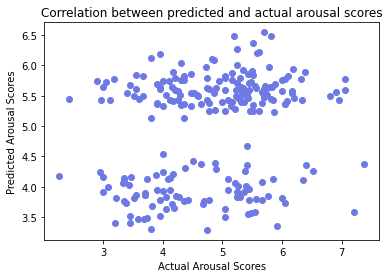

In [14]:
plt.scatter(actual_a_scores, predicted_a_scores, c='#6e79e4')

# font1 = {'family':'Bebas Neue','color':'blue','size':20}
# font2 = {'family':'Raleway','color':'darkred','size':15}

plt.title("Correlation between predicted and actual arousal scores")

plt.xlabel("Actual Arousal Scores")
plt.ylabel("Predicted Arousal Scores")
plt.show()

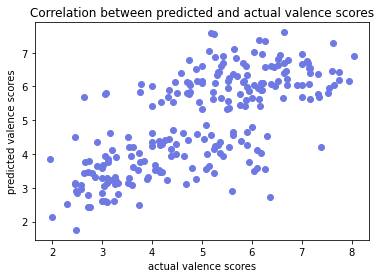

In [15]:
plt.scatter(actual_v_scores, predicted_v_scores, c='#6e79e4')
plt.title("Correlation between predicted and actual valence scores")

plt.xlabel("actual valence scores")
plt.ylabel("predicted valence scores")
plt.show()

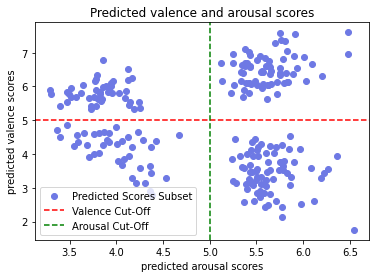

In [30]:
plt.scatter(predicted_a_scores, predicted_v_scores, c='#6e79e4')
plt.title("Predicted valence and arousal scores")

plt.axhline(y=5, c='red', linestyle='dashed', label="predicted scores")
plt.axvline(x=5, c='green', linestyle='dashed', label="horizontal")

plt.legend(("Predicted Scores Subset", "Valence Cut-Off", "Arousal Cut-Off"))

plt.xlabel("predicted arousal scores")
plt.ylabel("predicted valence scores")
plt.show()